# DVL-NAV -- Unit 770
04/06/2022
Gregory Burgess

---

1. [Import Libraries](#import-libraries)
1. [Load and Parse Data](#load-and-parse-data)
    1. [Bathymetry Data](#import-bathymetry)
    1. [Glider Flight Computer Data](#import-glider-flight-computer)
    1. [Rosbag Data](#import-rosbag-data)
    1. [Separate and Select Dives](#separate-and-select-dives)
    1. [DVL Data](#import-dvl-data)
1. [Compute Water Column Currents](#compute-water-column-currents)
1. [Compute DVL-Odometry](#compute-dvl-odometry)
1. [Multi-Factor Terrain Based Navigation](#multi-factor-terrain-based-navigation)
    <!-- 1. [Plot Navigation Results](#plot-navigation-results)
    1. [Navigation Performance](#navigation-performance)
        2. [Print Performance metrics](#print_metrics) -->
1. [More Plotting Tools](#more-plotting-tools)
1. [Sandbox](#sandbox)


---
<a id='import-libraries'></a>
## Import Libraries

In [73]:
import datetime
import earthpy as et
import earthpy.plot as ep
import importlib
import numpy as np
import os
import pandas as pd
import rasterio as rio
import scipy
import scipy.signal
import seaborn as sns 
import struct
import sys
import utm
import unittest
from PIL import Image
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join
from scipy.spatial.transform import Rotation as R
from scipy import interpolate

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
sys.path.append(os.path.join(sys.path[0], '../data'))

# objects for parsing raw DVL data 
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries

# objects for estimating ocean current velocities
import VelocityShearPropagation

# objects for controlling thruster to minimize transport cost 
import AdaptiveVelocityController

# objects for parsing flight and science computer log files
import SlocumFlightController
import SlocumScienceController
import dvl_plotter
import BathymetryMap
import MultiFactorTAN
import dvl_plotter_unit770_PR

# data for parsing seafloor bathymetry
import bathy_meta_data
sns.set()


import warnings
warnings.simplefilter('ignore')

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)
    importlib.reload(VelocityShearPropagation)
    importlib.reload(AdaptiveVelocityController)
    importlib.reload(SlocumFlightController)
    importlib.reload(SlocumScienceController)
    importlib.reload(dvl_plotter)
    importlib.reload(dvl_plotter_unit770_PR)
    importlib.reload(bathy_meta_data)
    importlib.reload(BathymetryMap)
    importlib.reload(MultiFactorTAN)
print('Done!')

Done!


In [6]:
#filepath = '/home/gburgess/dvl-nav/data/field_data/buzz_bay/dec_15/'
filepath = '/home/gburgess/dvl-nav/data/field_data/puerto_rico/mar17/'

---
<a id='load-and-parse-data'></a>
## Load and Parse Data
<a id='import-bathymetry'></a>
### Bathymetry Data

In [22]:
reload_modules()
# 1/9 arc second CUDEM used (approx 3.4m resolution)
# Grid_res_num should always represent original resolution of the bathymetry chart. Then, the Minimum spatial resolution will be half that.

# 3.4m resolution
# bathy_df = pd.read_csv('/home/gburgess/dvl-nav/data/field_data/kolumbo/bathy/Kolumbo-1.csv')
bathy_df = pd.read_csv('/home/gburgess/dvl-nav/data/field_data/puerto_rico/bathy/puertoRico_bathy.csv')
grid_res_num = 3.4

# 3.4m resolution
# bathy_df_var = pd.read_csv('/home/gburgess/dvl-nav/data/field_data/kolumbo/bathy/Kolumbo-2.csv')
bathy_df_var = pd.read_csv('/home/gburgess/dvl-nav/data/field_data/puerto_rico/bathy/puertoRico_bathy_var.csv')
map_var_resolution = '3.4m'

<a id='import-glider-flight-computer'></a>
### Glider Flight Computer Data

In [7]:
reload_modules()
directory = filepath+'dbd_parsed/'
ts_flight = SlocumFlightController.SlocumFlightController.from_directory(directory, save=False, verbose=False)
# ts_flight.df.to_csv('DBD_MAR17.csv', sep=',' , index=False)
# ts_flight.df.to_csv(filepath+'ts_flight.csv', sep=',' , index=False)
#ts_flight.df.head()

>> Parsing folder of ASC Files
>> Finished Parsing!


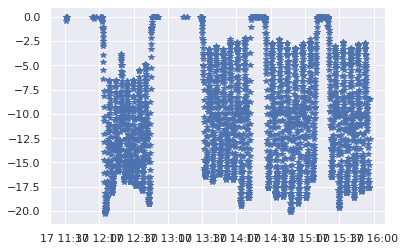

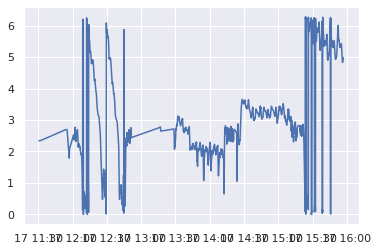

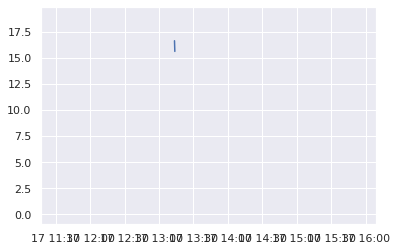

In [8]:
s = 0
e = -1
plt.figure()
#plt.plot(ts_flight.df.m_pitch*180/3.14)
plt.plot(ts_flight.df.m_depth[s:e]*-1, '*')

plt.figure()
plt.plot(ts_flight.df.m_heading[s:e])

plt.figure()
plt.plot(ts_flight.df.m_raw_altitude[s:e])

<a id='import-rosbag-data'></a>
### Rosbag Data

In [27]:
# CTD Sensor
#ctd_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'ctd-data.csv')

# IMU Sensor
# ahrs_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-spartonm2-ahrs.csv')

# # DVL Sensor
# dvl_df        = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-dvl.csv')
# dvl_pd0_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-pd0.csv')
# dvl_ranges_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-ranges.csv')
# dvl_raw_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-instrument-raw.csv')

# EXTCTL - GLider 
# m_lon_df        = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_lon.csv')
# m_lat_df        = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_lat.csv')
# m_gps_lon_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_gps_lon.csv')
# m_gps_lat_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_gps_lat.csv')
# m_depth_df      = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_depth.csv')
# m_pitch_df      = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_pitch.csv')
# m_roll_df       = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_roll.csv')
# m_altitude_df   = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_altitude.csv')
# m_alt_status_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_altimeter_status.csv')

# Micron Sonar

#TODO 

#split out m_gps_lat and m_lat (i think is deadreckoned ) for each dive
# Why are the m_lat and m_lon as well as m_gps_lat and m_gps_lon not 1:1 different lengths???


<a id='separate-and-select-dives'></a>
### Separate and Select Dives

Zeroing out CTD Data. Est Surface Depth: 3.299999952316284


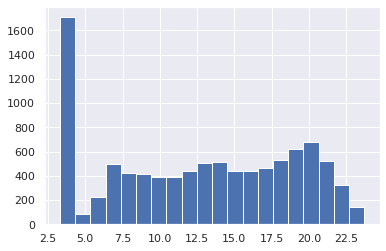

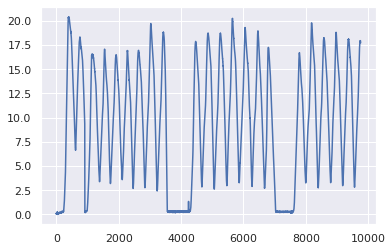

In [10]:
ctd_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'ctd-data.csv')
# "Zero" out CTD by determining the measured depth at which the glider spent the most time and under 6m
n, bins, patches = plt.hist(x=ctd_df.depth, bins= 'auto' )
bins
nbins = 0
for b in bins:
    if b > 6.0:
        break
    nbins += 1
#print(nbins)
target = n[0]
target_idx = 0
i = 0
for b in range(1,nbins):
    i = i+1
    if n[b] > target:
        target = n[b]
        target_idx = i
#print(target, target_idx, bins[target_idx])
est_surface_depth = bins[target_idx]
print('Zeroing out CTD Data. Est Surface Depth: ' + str(est_surface_depth))
ctd_df.depth = ctd_df.depth - est_surface_depth
plt.figure()
plt.plot(ctd_df.depth)


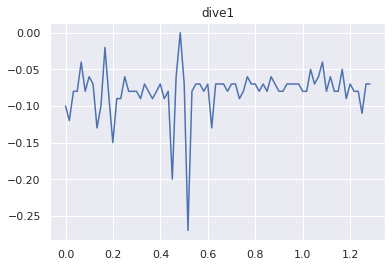

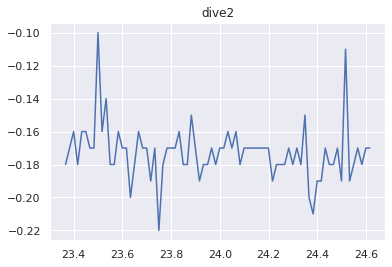

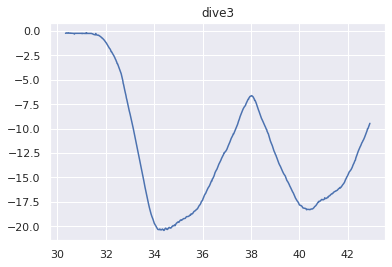

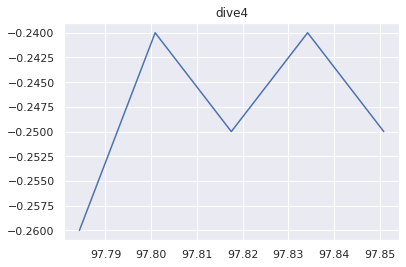

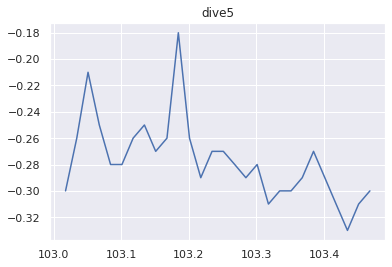

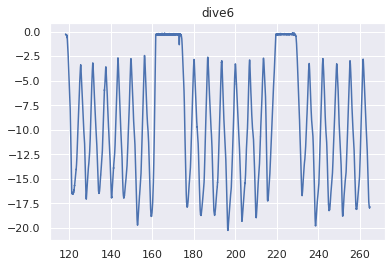

In [11]:
# Use CTD to determine start and end points of dives
dive_dic = {}
dive_dic['dive1'] = [0]
count = 0
for i in range(1,len(ctd_df.Time)):
    dt = ctd_df.Time[i] - ctd_df.Time[i-1]
    if dt > 5.0:
        count += 1
        dive_dic['dive'+str(count)].append(i-1)
        dive_dic['dive'+str(count+1)] = [i]
dive_dic['dive'+str(count+1)].append(len(ctd_df.Time)-1)

# Create DateTime Column to make it easier to read
#ctd_df['Time'] = pd.to_datetime(ctd_df['header.stamp.secs'], unit='s')
ctd_df['Time_easy'] = (ctd_df['Time'] - ctd_df.Time[0])/60
for key in dive_dic:
    plt.figure()
    plt.plot(ctd_df.Time_easy[dive_dic[key][0]:dive_dic[key][1]], ctd_df.depth[dive_dic[key][0]:dive_dic[key][1]]*-1)
    plt.title(key)


### Select Dive

In [12]:
selected_dive = 'dive6'

---
### Based upon selected dive, split out flight computer data and DVL data
Flight Computer

2022-03-17 08:29:37.734078 2022-03-17 10:56:25.314692
Duration: 2:26:47.580614
2022-03-17 13:29:04.434078 2022-03-17 15:55:52.014692


Text(0.5, 1.0, 'Depth from .dbd')

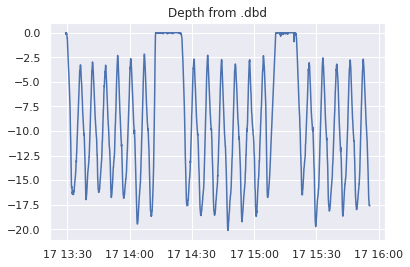

In [13]:
ctd_start = ctd_df.Time[dive_dic[selected_dive][0]]
ctd_end = ctd_df.Time[dive_dic[selected_dive][1]]
print(datetime.datetime.fromtimestamp(ctd_start), datetime.datetime.fromtimestamp(ctd_end))

# time_zone_shift = 3600*5
time_zone_shift = 3600*(5-0.00925)

start_t = datetime.datetime.fromtimestamp(ctd_start+time_zone_shift)
end_t   = datetime.datetime.fromtimestamp(ctd_end+time_zone_shift)
dur     = end_t - start_t 
print("Duration:", dur)
print(start_t, end_t)

df_dbd  = ts_flight.df[str(start_t):str(end_t)].copy()
# df_dbd.to_csv(filepath+'mar17_bad_dive_flight_data.csv', sep=',', index=False)

plt.figure()
plt.plot(df_dbd.m_depth*-1)
plt.title('Depth from .dbd')



Interpolate AHRS and CTD Data to enable matching data to DVL timestamp

In [14]:
# Interpolate AHRS and CTD data onto DVL timestamp. Simplest solution for post-processing.
# TODO consider how to trasnfer this to live application

ahrs_df = pd.read_csv(filepath + 'rosbags/rosbag_output/' + 'devices-spartonm2-ahrs.csv')
# ahrs_df.head()
f_roll = scipy.interpolate.interp1d(ahrs_df.Time, ahrs_df.roll, 'nearest')
f_pitch = scipy.interpolate.interp1d(ahrs_df.Time, ahrs_df.pitch, 'nearest')
f_heading = scipy.interpolate.interp1d(ahrs_df.Time, ahrs_df['compass.heading'], 'nearest')

time_dbd = df_dbd.time- time_zone_shift
# RAD_TO_DEG = 180/scipy.pi
# # #Mar 11 and Mar 14 - use TCM3
# f_roll = scipy.interpolate.interp1d(time_dbd, df_dbd.m_roll * RAD_TO_DEG, 'linear')
# f_pitch = scipy.interpolate.interp1d(time_dbd, df_dbd.m_pitch * RAD_TO_DEG, 'linear')
# f_heading = scipy.interpolate.interp1d(time_dbd, df_dbd.m_heading * RAD_TO_DEG, 'linear')

# CTD
f_depth = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.depth, 'linear')
f_temp = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.temperature, 'linear')
f_cond = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.conductivity, 'linear')

DVL Data

In [15]:
# Upload DVL rosbags
dvl_df        = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-dvl.csv')
dvl_pd0_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-pd0.csv')
dvl_ranges_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-ranges.csv')
dvl_raw_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-instrument-raw.csv')

dvl_raw_df_new = dvl_raw_df.set_index('Time')

start_dvl = dvl_raw_df_new.index.get_loc(ctd_start, method='nearest')
end_dvl = dvl_raw_df_new.index.get_loc(ctd_end, method='nearest')
print(start_dvl, end_dvl)

7797 16605


In [16]:
# Specific to when using DBD data as IMU
print('DBD Start: ', time_dbd[0], ' DBD END: ', time_dbd[-1])
print('DVL Start: ', dvl_raw_df.Time[start_dvl], ' DVL END: ', dvl_raw_df.Time[end_dvl])
print('Diff start: ',time_dbd[0] -dvl_raw_df.Time[start_dvl]  , ' Diff end: ', time_dbd[-1] -dvl_raw_df.Time[end_dvl])

DBD Start:  1647520182.19331  DBD END:  1647528978.75337
DVL Start:  1647520177.295477  DVL END:  1647528985.03466
Diff start:  4.8978331089019775  Diff end:  -6.281290054321289


In [17]:
# Specific to when using DBD data as IMU
print('CTD Start: ', ctd_start, ' CTD end: ', ctd_end)
print('DBD Start: ', time_dbd[0], ' DBD END: ', time_dbd[-1])
print('Diff start: ',time_dbd[0] - ctd_start  , ' Diff end: ', time_dbd[-1] - ctd_end)

start_adjustment = int(np.ceil(time_dbd[0] - ctd_start))
end_adjustment = int(np.ceil(np.abs(time_dbd[-1] - ctd_end)))


CTD Start:  1647520177.7340784  CTD end:  1647528985.3146915
DBD Start:  1647520182.19331  DBD END:  1647528978.75337
Diff start:  4.459231615066528  Diff end:  -6.561321496963501


In [ ]:
# reload_modules()
# # Initialize Timseries object
# ts = PathfinderTimeSeries.PathfinderTimeSeries()
# prev_ensemble = None
# error_count = 0
# for i in range(0,len(dvl_raw_df.Time)):
#     try:
#         ros_timestamp = dvl_raw_df.Time[i]
#         roll = f_roll(ros_timestamp)
#         pitch = f_pitch(ros_timestamp)
#         heading = f_pitch(ros_timestamp)

#         ensemble_raw = dvl_raw_df.data[i][2:-1]
#         ensemble_bytes = ensemble_raw.encode().decode('unicode_escape').encode("raw_unicode_escape")
#         ensemble = PathfinderEnsemble.PathfinderEnsemble(ensemble_bytes, prev_ensemble, gps_fix=None, ros_time=ros_timestamp, \
#                                                          ext_roll=roll, ext_pitch=pitch, ext_heading=heading)
#         ts.add_ensemble(ensemble)
#         prev_ensemble = ensemble
#     except:
#         error_count += 1
#         continue
# ts.to_dataframe()
# print('Error Count: ' + str(error_count))
# ts.df.to_csv('DVL_MAR9.csv', sep=',' , index=False)
#TODO add dvl odo in ??

In [66]:
reload_modules()
# Initialize Timseries object
ts = PathfinderTimeSeries.PathfinderTimeSeries()
prev_ensemble = None
error_count = 0
for i in range(start_dvl + start_adjustment, end_dvl-end_adjustment):
    ros_timestamp = dvl_raw_df.Time[i]
    roll = f_roll(ros_timestamp)
    pitch = f_pitch(ros_timestamp)
    heading = f_heading(ros_timestamp)
    depth = f_depth(ros_timestamp)
    temp = f_temp(ros_timestamp)
    cond = f_cond(ros_timestamp)
    ensemble_raw = dvl_raw_df.data[i][2:-1]
    ensemble_bytes = ensemble_raw.encode().decode('unicode_escape').encode("raw_unicode_escape")
    ensemble = PathfinderEnsemble.PathfinderEnsemble(ensemble_bytes, prev_ensemble, gps_fix=None, ros_time=ros_timestamp, \
                                                    ext_roll=roll, ext_pitch=pitch, ext_heading=heading, \
                                                    ext_depth=depth, ext_temp=temp, ext_cond=cond)
    ts.add_ensemble(ensemble)
    prev_ensemble = ensemble

                
ts.to_dataframe()
# ts.df.to_csv('DVL_DIVEXX.csv')
print(error_count)

In [ ]:
# # Use this block to save all DVL timeseries for each dive

# reload_modules()
# # Set False if Sparton AHRS wasn't working
# SPARTON = False

# # Constants
# time_zone_shift = 3600*5
# RAD_TO_DEG = 180/scipy.pi

# # CTD
# f_depth = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.depth, 'linear')
# f_temp = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.temperature, 'linear')
# f_cond = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.conductivity, 'linear')

# if SPARTON:
#     ahrs_df = pd.read_csv(filepath + 'rosbags/rosbag_output/' + 'devices-spartonm2-ahrs.csv')
#     f_roll = scipy.interpolate.interp1d(ahrs_df.Time, ahrs_df.roll, 'nearest')
#     f_pitch = scipy.interpolate.interp1d(ahrs_df.Time, ahrs_df.pitch, 'nearest')
#     f_heading = scipy.interpolate.interp1d(ahrs_df.Time, ahrs_df['compass.heading'], 'nearest')
# dives_to_be_parsed = ['dive4', 'dive5', 'dive6', 'dive7', 'dive8', 'dive9', 'dive10', 'dive11', 'dive12', 'dive13', \
#                         'dive14', 'dive15', 'dive16', 'dive17', 'dive18', 'dive19', 'dive20', 'dive21', 'dive22', 'dive23', \
#                           'dive24', 'dive25', 'dive26', 'dive27']
# for key in dives_to_be_parsed:
#     # Section out CTD time by dive
#     ctd_start = ctd_df.Time[dive_dic[key][0]]
#     ctd_end = ctd_df.Time[dive_dic[key][1]]

#     # Section out Flight Computer Data
#     start_t = datetime.datetime.fromtimestamp(ctd_start+time_zone_shift)
#     end_t   = datetime.datetime.fromtimestamp(ctd_end+time_zone_shift)
#     dur     = end_t - start_t 
#     df_dbd  = ts_flight.df[str(start_t):str(end_t)].copy()
#     # Account for time zone shift
#     time_dbd = df_dbd.time - time_zone_shift
#     if not SPARTON:
#         f_roll = scipy.interpolate.interp1d(time_dbd, df_dbd.m_roll * RAD_TO_DEG, 'linear')
#         f_pitch = scipy.interpolate.interp1d(time_dbd, df_dbd.m_pitch * RAD_TO_DEG, 'linear')
#         f_heading = scipy.interpolate.interp1d(time_dbd, df_dbd.m_heading * RAD_TO_DEG, 'linear')

#     # Section out DVL Data
#     start_dvl = dvl_raw_df_new.index.get_loc(ctd_start, method='nearest')
#     end_dvl = dvl_raw_df_new.index.get_loc(ctd_end, method='nearest')

#     # Initialize Timseries object
#     ts = PathfinderTimeSeries.PathfinderTimeSeries()
#     prev_ensemble = None
#     error_count = 0
#     for i in range(start_dvl,end_dvl):
#             try:
#                     ros_timestamp = dvl_raw_df.Time[i]
#                     roll = f_roll(ros_timestamp)
#                     pitch = f_pitch(ros_timestamp)
#                     heading = f_heading(ros_timestamp)
#                     depth = f_depth(ros_timestamp)
#                     temp = f_temp(ros_timestamp)
#                     cond = f_cond(ros_timestamp)
#                     ensemble_raw = dvl_raw_df.data[i][2:-1]
#                     ensemble_bytes = ensemble_raw.encode().decode('unicode_escape').encode("raw_unicode_escape")
#                     ensemble = PathfinderEnsemble.PathfinderEnsemble(ensemble_bytes, prev_ensemble, gps_fix=None, ros_time=ros_timestamp, \
#                                                                     ext_roll=roll, ext_pitch=pitch, ext_heading=heading, \
#                                                                     ext_depth=depth, ext_temp=temp, ext_cond=cond)
#                     ts.add_ensemble(ensemble)
#                     prev_ensemble = ensemble
#             except:
#                     error_count += 1
#                     continue
#     ts.to_dataframe()
    
#     ts.df.to_csv('/home/gburgess/dvl-nav/notebook/output/DVL_' + str(key) + '.csv')

---
<a id='compute-water-column-currents'></a>
## Compute Water Column Currents


> Finished Estimating Water Column Currents!
Water Column (depth=60) 
|z =  0| V[   0,   0,   0]
|z =  2| V[   0,   0,   0]
|z =  4| V[   0,   0,   0]
|z =  6| V[   0,   0,   0]
|z =  8| V[   0,   0,   0]
|z = 10| V[   0,   0,   0]
|z = 12| V[   0,   0,   0]
|z = 14| V[   0,   0,   0]
|z = 16| V[   0,  -1,   0]
|z = 18| V[  -4,   0,   0]
|z = 20| V[   0,   5,   0]
|z = 22| V[   2,   8,   0]
|z = 24| V[   8,  -3,   0]
|z = 26| V[  14,   0,   0]
|z = 28| V[   9,  -2,   0]
|z = 30| V[  -9,   0,   0]
|z = 32| V[----,----,----]
|z = 34| V[----,----,----]
|z = 36| V[----,----,----]
|z = 38| V[----,----,----]
|z = 40| V[----,----,----]
|z = 42| V[----,----,----]
|z = 44| V[----,----,----]
|z = 46| V[----,----,----]
|z = 48| V[----,----,----]
|z = 50| V[----,----,----]
|z = 52| V[----,----,----]
|z = 54| V[----,----,----]
|z = 56| V[----,----,----]
|z = 58| V[----,----,----]



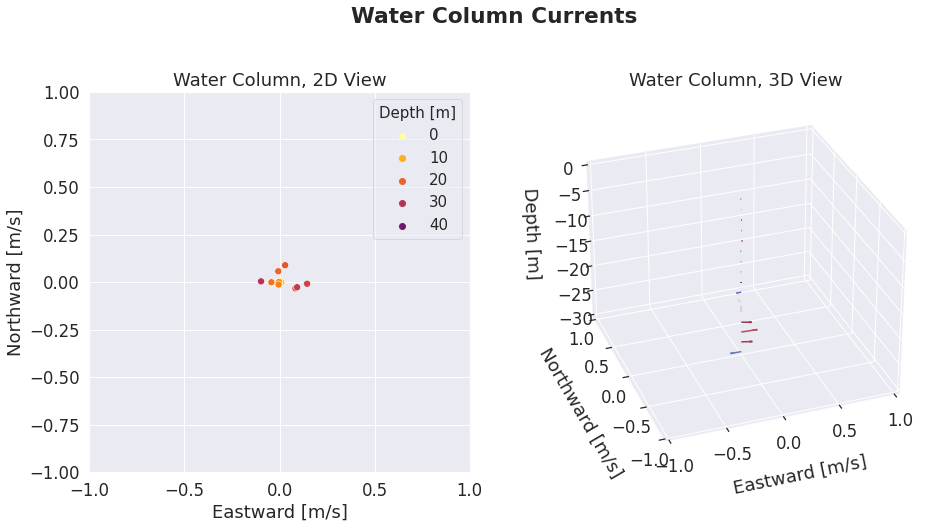

In [67]:
reload_modules()

btm_count = 0
# tuning parameters for working with DVL data 
pitch_bias           = 0
#pitch_bias           =  8    # [deg]   mounting pitch bias for the sonar
start_filter         =  2    # [bin #] avoid using the first number of bins
end_filter           =  2    # [bin #] avoid using the last number of bins 
voc_mag_filter       =  1.0  # [m/s]   filter out ocean current 
voc_delta_mag_filter =  0.5  # [m/s]   filter out deltas between layers
near_surface_filter  = 10    # [m]     ignore Vtw when near surface 
direction = 'descending'

# constants
DEG_TO_RAD = np.pi/180

# determine DVL parameters 
bin_len      = ts.df.depth_bin_length[0]
bin0_dist    = ts.df.bin0_distance[0]
bin_len      = np.cos(pitch_bias*DEG_TO_RAD)*bin_len
bin0_dist    = np.cos(pitch_bias*DEG_TO_RAD)*bin0_dist
max_range    = 40
max_depth    = int(np.max(ts.df.ctd_depth)+max_range)
x_beam       = 0
y_beam       = 1

# intialize water column
water_column = VelocityShearPropagation.WaterColumn(
    bin_len=bin_len, 
    bin0_dist=bin0_dist,
    max_depth=max_depth,
    start_filter=start_filter,
    end_filter=end_filter,
    voc_mag_filter=voc_mag_filter,
    voc_delta_mag_filter=voc_delta_mag_filter,
)

# iterate over the DVL ensembles 
for t in range(len(ts.df)):

    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.ctd_depth[t]
    pitch = ts.df.ahrs_pitch[t]
    roll  = ts.df.ahrs_roll[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    #print(vtw_u, vtw_v)
    # extract Voc reference from bottom track velocity when available
    if not np.isnan(ts.df.abs_vel_btm_u[t]):
        vog_u = ts.df.abs_vel_btm_u[t]
        vog_v = ts.df.abs_vel_btm_v[t]
        voc_u = vog_u - vtw_u
        voc_v = vog_v - vtw_v
        voc_ref = VelocityShearPropagation.OceanCurrent(voc_u, voc_v, 0)
        # print(vog_u, vog_v)
        btm_count = btm_count +1
    else:
        voc_ref = VelocityShearPropagation.OceanCurrent()
        
    # add shear nodes for each DVL depth bin that meet the filter criteria
    num_good_vel_bins = ts.df.num_good_vel_bins[t]
    if num_good_vel_bins > start_filter+end_filter:        
        
        # determine if glider ascending or descending
        delta_z = ts.df.delta_z[t] 
        if delta_z > 0:
            direction = 'descending'
        else:
            direction = 'ascending'

        # build list of velocity shears to add as ShearNode to water column
        delta_voc_u = []
        delta_voc_v = []

        # add all valid DVL bins to the shear list 
        #   + filtering of DVL bins will occur in the `add_shear_node` call
        for bin_num in range(int(num_good_vel_bins)):

            # retrieve the shear list from the DVL data 
            x_var = ts.get_profile_var_name('velocity', bin_num, x_beam)
            y_var = ts.get_profile_var_name('velocity', bin_num, y_beam)
            dvl_x = ts.df[x_var][t]
            dvl_y = ts.df[y_var][t]

            # compute delta between dead-reckoned through-water velocity & DVL
            delta_voc_u.append(vtw_u - (-dvl_x))
            delta_voc_v.append(vtw_v - (-dvl_y))

        shear_list = [VelocityShearPropagation.OceanCurrent(
                        delta_voc_u[i], 
                        delta_voc_v[i], 
                        0) 
                      for i in range(len(delta_voc_u))]

        # add shear node to the water column with shear list information 
        if len(shear_list):
            water_column.add_shear_node(
                z_true=depth,
                t=t,
                shear_list=shear_list,
                voc_ref=voc_ref,
                direction=direction,
                pitch=pitch,
                roll=roll,
            )

    # add voc_ref measurement to the water column even if shear list is empty  
    elif not voc_ref.is_none():
        water_column.add_shear_node(
            z_true=depth,
            t=t,
            shear_list=[],
            voc_ref=voc_ref,
            direction=direction,
            pitch=pitch,
            roll=roll,
        )
        
voc_u_list,voc_v_list,voc_w_list, z_list = water_column.compute_averages()
print("> Finished Estimating Water Column Currents!")
print(water_column.averages_to_str())
dvl_plotter.plot_water_column_currents(voc_u_list, voc_v_list, voc_w_list, z_list, save_name='tmp-water-column.png')

In [20]:
btm_count

8603

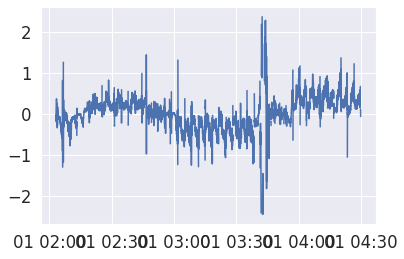

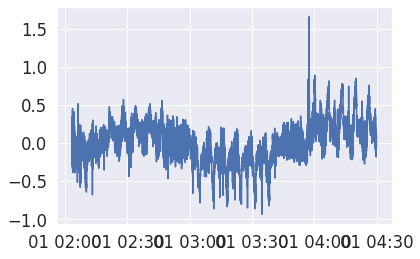

In [22]:
plt.figure()
plt.plot(ts.df.rel_vel_pressure_v)

plt.figure()
plt.plot(ts.df.rel_vel_dvl_v)


---
<a id='compute-dvl-odometry'></a>
## Compute DVL-Odometry

In [68]:
#TODO add in ability to synthetically remove bottom lock

def get_utm_coords_from_glider_lat_lon(m_lat, m_lon):
    SECS_IN_MIN = 60
    MIN_OFFSET = 100
    lat_min  = m_lat % MIN_OFFSET 
    lon_min  = m_lon % MIN_OFFSET 
    lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
    lon_dec  = (m_lon - lon_min)/MIN_OFFSET + lon_min/SECS_IN_MIN
    utm_pos  = utm.from_latlon(lat_dec, lon_dec)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    zone_letter  = utm_pos[3]
    return(easting, northing, zone, zone_letter)

# How long (in mins) will algorithm accept ocean current estimates i.e. forgetting factor
ocean_current_time_filter = 12.5 # mins
MIN_NUM_NODES = 12

# extract start_t position "origin" from the glider flight data 
for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x_lmc = df_dbd.m_x_lmc[t]
        dbd_origin_y_lmc = df_dbd.m_y_lmc[t]
        dbd_origin_m_lat = df_dbd.m_lat[t]
        dbd_origin_m_lon = df_dbd.m_lon[t]
        break

dbd_utm_x, dbd_utm_y, zone_number, zone_letter = get_utm_coords_from_glider_lat_lon(
    dbd_origin_m_lat, 
    dbd_origin_m_lon
)

# initialize list for new odometry
rel_pos_x = [0]
rel_pos_y = [0]
rel_pos_z = [0]
delta_x_list = [0]
delta_y_list = [0]
# rel_pos_x_utm = [0]
# rel_pos_y_utm = [0]
vel_list_x = []
vel_list_y = []
u_list     = []
v_list     = []
# set flag for setting GPS updates
flag_gps_fix_at_surface = False 

# iterate through the dive file to update odometry
for t in range(1,len(ts.df)):
    time    = ts.df.ros_timestamp[t]
    prev_x  = rel_pos_x[-1]
    prev_y  = rel_pos_y[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.ctd_depth[t]
    
    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.ctd_depth[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        flag_gps_fix_at_surface = False
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # retrieve over ground velocity from DVL in bottom track 
    vog_u = ts.df.abs_vel_btm_u[t]
    vog_v = ts.df.abs_vel_btm_v[t]
    #################################################################
    # retrieve ocean current estimate from water column 
    good_node_list = []
    count = 0
    cum_voc_u = 0
    cum_voc_v = 0
    # Extract all shear nodes at current depth
    wc_depth = water_column.get_wc_bin(depth)
    node_list = water_column.get_voc_at_depth(wc_depth)

    #Iterate through shear nodes at depth
    for shear_node in node_list:
        voc = shear_node.voc
        if not(voc.is_none()):
            # filter out large values when computing averages
            if voc.mag < voc_mag_filter:
                good_node_list.append(shear_node)
    ####################################################################
    if (len(good_node_list) > 0):
            for i in range(len(good_node_list)):
                if i == 0:
                    count += 1
                    cum_voc_u += good_node_list[0].voc.u
                    cum_voc_v += good_node_list[0].voc.v
                elif (i <= MIN_NUM_NODES):
                    count += 1
                    cum_voc_u += good_node_list[i].voc.u
                    cum_voc_v += good_node_list[i].voc.v
                else: 
                    time_between_current_estimates = good_node_list[i].t - good_node_list[0].t
                    if time_between_current_estimates > (ocean_current_time_filter*60):
                        count += 1 
                        cum_voc_u += good_node_list[i].voc.u
                        cum_voc_v += good_node_list[i].voc.v
            #voc_avg = OceanCurrent(cum_voc_u/count, cum_voc_v/count, 0)
            voc_u = cum_voc_u/count
            voc_v = cum_voc_v/count
            u_list.append(voc_u)
            v_list.append(voc_v)             
    else:
        voc_u = np.nan
        voc_v = np.nan
        u_list.append(voc_u)
        v_list.append(voc_v)

    #################################################################
    # initialize delta values to zero
    delta_x, delta_y = 0,0
    
    # CASE 1: use bottom track overground velocity if available
    if (not np.isnan(vog_u)):
        delta_x = vog_u*delta_t
        delta_y = vog_v*delta_t
        vel_list_x.append(vog_u)
        vel_list_y.append(vog_v)
    
    # CASE 2: use through water velocity and ocean current estimate if available
    elif (not np.isnan(vtw_u)) and (not np.isnan(voc_u)):
            delta_x = (vtw_u + voc_u)*delta_t
            delta_y = (vtw_v + voc_v)*delta_t
            vel_list_x.append(vtw_u + voc_u)
            vel_list_y.append(vtw_v + voc_v)
    # CASE 3: use through water velocity if available
    elif (not np.isnan(vtw_u)):
            delta_x = vtw_u*delta_t
            delta_y = vtw_v*delta_t
            vel_list_x.append(vtw_u)
            vel_list_y.append(vtw_v)
    # CASE 4: use ocean current estimate if available
    elif (not np.isnan(voc_u)):
            delta_x = voc_u*delta_t
            delta_y = voc_v*delta_t
            vel_list_x.append(voc_u)
            vel_list_y.append(voc_v)

    # set current position to DVL odometry result 
    cur_x = delta_x + prev_x
    cur_y = delta_y + prev_y
    
    # override current position if GPS fix is given 
    if depth < near_surface_filter:
        cur_time = datetime.datetime.fromtimestamp(time+time_zone_shift)
        cur_dbd  = df_dbd[str(cur_time):].copy()
        if (len(cur_dbd.m_gps_x_lmc) != 0):
            if not np.isnan(cur_dbd.m_gps_x_lmc[0]):
                cur_x = cur_dbd.m_gps_x_lmc[0] - dbd_origin_x_lmc
                cur_y = cur_dbd.m_gps_y_lmc[0] - dbd_origin_y_lmc
                flag_gps_fix_at_surface = True
                
                vel_list_x.append(cur_dbd.m_vx_lmc[0])
                vel_list_y.append(cur_dbd.m_vy_lmc[0])
    
    # update the odometry list of positions
    rel_pos_x.append(cur_x)
    rel_pos_y.append(cur_y)
    rel_pos_z.append(depth)
    delta_x_list.append(delta_x)
    delta_y_list.append(delta_y)
    
    

# rel_pos_x_noBL = rel_pos_x
# rel_pos_y_noBL = rel_pos_y
# add new odomety to the data frame
ts.df['rel_pos_x'] = rel_pos_x
ts.df['rel_pos_y'] = rel_pos_y
ts.df['rel_pos_z'] = rel_pos_z
ts.df['delta_x']   = delta_x_list
ts.df['delta_y']   = delta_y_list

print("> Finished Calculating Odometry!")

> Finished Calculating Odometry!


---
## Plot Navigation Results 

### Produce UTM and Lat/Lon Re-Nav Estimates

In [76]:
# extract start_t position "origin" from the glider flight data 
for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x_lmc = df_dbd.m_x_lmc[t]
        dbd_origin_y_lmc = df_dbd.m_y_lmc[t]
        dbd_origin_m_lat = df_dbd.m_lat[t]
        dbd_origin_m_lon = df_dbd.m_lon[t]
        break

# Convert starting lat lon to UTM
dbd_origin_utm_x, dbd_origin_utm_y, zone_number, zone_letter = get_utm_coords_from_glider_lat_lon(
    dbd_origin_m_lat, 
    dbd_origin_m_lon
)

# Generate DVL-ODO estimate of position in UTM coordinates
rel_pos_x_utm = ts.df['rel_pos_x'] + dbd_origin_utm_x
rel_pos_y_utm = ts.df['rel_pos_y'] + dbd_origin_utm_y
utm_dr_x      = df_dbd['m_x_lmc'] + dbd_origin_utm_x
utm_dr_y      = df_dbd['m_y_lmc'] + dbd_origin_utm_y
utm_gps_x     = df_dbd['m_gps_x_lmc'] + dbd_origin_utm_x
utm_gps_y     = df_dbd['m_gps_y_lmc'] + dbd_origin_utm_y

# Convert DVL-ODO estimate of position to lat/lon
rel_pos_y_lat, rel_pos_x_lon = utm.to_latlon(rel_pos_x_utm, rel_pos_y_utm, zone_number, zone_letter)

# Function for converting DDMM.XX lat and lon to DD.XXX
def decimal_minutes_to_decimal_degrees(m_lat, m_lon):
    SECS_IN_MIN = 60
    MIN_OFFSET = 100
    lat_min  = m_lat % MIN_OFFSET 
    lon_min  = m_lon % MIN_OFFSET 
    lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
    lon_dec  = (m_lon - lon_min)/MIN_OFFSET + lon_min/SECS_IN_MIN
    return lat_dec,lon_dec

# Generate DR estimate from glider and gps fixes from glider to lat/lon
m_lat_DD, m_lon_DD = decimal_minutes_to_decimal_degrees(df_dbd['m_lat'], df_dbd['m_lon'])
m_lat_GPS, m_lon_GPS = decimal_minutes_to_decimal_degrees(df_dbd['m_gps_lat'], df_dbd['m_gps_lon'])

# UTM
df_dbd['utm_dr_x']      = utm_dr_x
df_dbd['utm_dr_y']      = utm_dr_y
df_dbd['utm_gps_x']     = utm_gps_x
df_dbd['utm_gps_y']     = utm_gps_y
ts.df['rel_pos_x_utm'] = (ts.df['rel_pos_x'] + dbd_origin_utm_x)
ts.df['rel_pos_y_utm'] = (ts.df['rel_pos_y'] + dbd_origin_utm_y)

# Lat/Lon in Decimal Degrees which matches how utm library converts utm to lat/lon
df_dbd['m_lat_DD']       = m_lat_DD
df_dbd['m_lon_DD']       = m_lon_DD
df_dbd['m_lat_gps_DD']   = m_lat_GPS
df_dbd['m_lon_gps_DD']   = m_lon_GPS
ts.df['rel_pos_lon'] = rel_pos_x_lon
ts.df['rel_pos_lat'] = rel_pos_y_lat

# plt.figure()
# plt.plot(m_lon_DD, m_lat_DD)
# plt.plot(m_lon_GPS, m_lat_GPS)
# plt.plot(rel_pos_x_lon, rel_pos_y_lat, '.')
# plt.axis('equal')

# plt.figure()
# plt.plot(df_dbd.m_lon, df_dbd.m_lat)
# plt.plot(df_dbd.m_gps_lon, df_dbd.m_gps_lat)


# plt.figure()
# plt.plot(df_dbd.m_x_lmc, df_dbd.m_y_lmc)
# plt.plot(df_dbd.m_gps_x_lmc, df_dbd.m_gps_y_lmc)

# plt.figure()
# plt.plot(ts.df.rel_pos_x_utm, ts.df.rel_pos_y_utm)

# plt.figure()
# plt.plot(ts.df.rel_pos_lon, ts.df.rel_pos_lat)


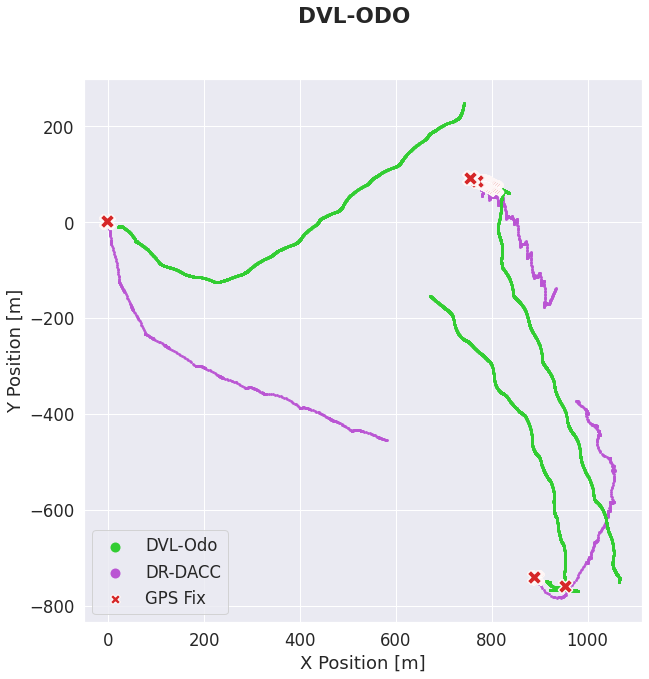

In [77]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale = 1.5)
linewidth = 8
plt_bg = True

# sns.scatterplot(
#     tan_pos_x, 
#     tan_pos_y, 
#     linewidth=0, 
#     color='tab:orange', 
#     label='MF-TAN',
#     s=linewidth, 
#     zorder=4,
# )
# odos=3

# sns.scatterplot(
#     sf_tan_pos_x, 
#     sf_tan_pos_y, 
#     linewidth=0, 
#     color='black', 
#     label='SF-TAN',
#     s=10, 
#     zorder=3,
# )
# odos=4

sns.scatterplot(
    ts.df.rel_pos_x - dbd_origin_x_lmc, 
    ts.df.rel_pos_y - dbd_origin_y_lmc, 
    linewidth=0, 
    color='limegreen', 
    label='DVL-Odo',
    s=linewidth, 
    zorder=2,
)
odos=1

# sns.scatterplot(
#     #ts.df.rel_pos_x, 
#     rel_pos_x_noBL,
#     rel_pos_y_noBL,
#     #ts.df.rel_pos_y, 
#     linewidth=0, 
#     color='mediumorchid', 
#     label='NO-BL',
#     s=linewidth, 
#     zorder=2,
# )

sns.scatterplot(
    x=df_dbd.m_x_lmc - dbd_origin_x_lmc,
    y=df_dbd.m_y_lmc - dbd_origin_y_lmc,
    color='mediumorchid',
    label='DR-DACC',
    linewidth=0,
    s=linewidth,
    data=df_dbd,
    zorder=1,
)
odos=2

# sns.scatterplot(
#     tan_update_x, 
#     tan_update_y, 
#     zorder=4, 
#     marker='^', 
#     label='MF-TAN Fix',
#     s=60,
# )

# sns.scatterplot(
#     tan_update_x_SF, 
#     tan_update_y_SF, 
#     zorder=6, 
#     marker='^',
#     label='SF-TAN Fix',
#     s=80,
# )
# sns.scatterplot(
#     tan_update_x, 
#     tan_update_y, 
#     zorder=5, 
#     marker='^', 
#     label='MF-TAN Fix',
#     s=60,
# )

sns.scatterplot(
    x=df_dbd.m_gps_x_lmc - dbd_origin_x_lmc, 
    y=df_dbd.m_gps_y_lmc - dbd_origin_y_lmc,
    marker='X',
    color='tab:red', 
    s=200,
    label='GPS Fix',
    data=df_dbd,
    zorder=7,
)
odos=3

lgnd = plt.legend(loc='lower left')
for i in range(odos):
    lgnd.legendHandles[i]._sizes = [100]

plt.axis('equal')
xlim=ax.get_xlim()
ylim=ax.get_ylim()

# MFTAN_bg = np.array(bathy_df.slope_list)
# bg_threshold = 30
# MFTAN_bg[MFTAN_bg>bg_threshold] = bg_threshold
# MFTAN_bg[0] = 3*np.nanmax(MFTAN_bg)

# if plt_bg:
#     sns.scatterplot(
#         bathy_df.utm_x_list - dbd_utm_x,
#         bathy_df.utm_y_list - dbd_utm_y,
#         bathy_df.slope_list,
#         marker='s',
#         ax=ax,
#         s=200,
# #         s=80,
# #         s=20,
#         palette="gray_r",
#         linewidth=0,
#         zorder=0,
#         legend=False,
#     )
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xlabel('X Position [m]')
plt.ylabel('Y Position [m]')
plt.suptitle('DVL-ODO', fontweight='bold')
#plt.suptitle('MF-TAN: Dive %s '%dive_label +'-- Map Var Resolution: %s'%map_var_resolution,  fontweight='bold')
#plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
#plt.close()
#print('> Done plotting!')
plt.show()

# ts.df.head()
# plt.figure()
# plt.plot(ts.df.btm_beam0_range)
# plt.plot(ts.df.btm_beam1_range)
# plt.plot(ts.df.btm_beam2_range)
# plt.plot(ts.df.btm_beam3_range)

# plt.figure()
# plt.plot(ts.df.ahrs_pitch)

# plt.figure()
# plt.plot(ts.df.ahrs_roll)

# plt.figure()
# plt.plot(ts.df.ahrs_heading)
# plt.figure()
# plt.plot(df_dbd.m_heading * 180/3.14, 'r')

---
<a id='multi-factor-terrain-based-navigation'></a>
## Multi-Factor Terrain Based Navigation (MF-TAN)

In [116]:
reload_modules()

def get_utm_coords_from_glider_lat_lon(m_lat, m_lon):
    SECS_IN_MIN = 60
    MIN_OFFSET = 100
    lat_min  = m_lat % MIN_OFFSET 
    lon_min  = m_lon % MIN_OFFSET 
    lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
    lon_dec  = (m_lon - lon_min)/MIN_OFFSET + lon_min/SECS_IN_MIN
    utm_pos  = utm.from_latlon(lat_dec, lon_dec)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    zone_letter  = utm_pos[3]
    return(easting, northing, zone, zone_letter)

# constants
JANUS_ANGLE = 30
DEG_TO_RAD  = np.pi/180
RAD_TO_DEG  = 1/DEG_TO_RAD
sin_janus   = np.sin(JANUS_ANGLE*DEG_TO_RAD)
cos_janus   = np.cos(JANUS_ANGLE*DEG_TO_RAD)
min_valid_slant_ranges = 3 

# AUG parameters
# BIAS_PITCH   = 12.5  # [deg]
BIAS_PITCH   =  0.0  # [deg]
BIAS_ROLL    =  0.0  # [deg]
BIAS_HEADING =  0.0  # [deg]

# # TAN parameters 1st attempt Puerto Rico Mar 17
DVL_ODO_DRIFT = 0.60 #Heuristic that determines growth of uncertaintyh based on worst-case DVL-ODO performance history
TAN_RED_DRIFT = 0.70 #Every time there is a a valid MF-TAN fix, reduces r (positional uncertainty) by 30%
TAN_WEIGHT    = 0.5

# # TAN parameters
############################
# Long Dive (Dive A) ########
# DVL_ODO_DRIFT = 0.15 #Heuristic that determines growth of uncertaintyh based on worst-case DVL-ODO performance history
# DVL_ODO_DRIFT = 0.60
# TAN_RED_DRIFT = 0.70 #Every time there is a a valid MF-TAN fix, reduces r (positional uncertainty) by 30%
# TAU_DEPTH     = 2
# TAU_SLOPE     = 2
# TAU_ORIENT    = 4
# MIN_PITCH_FOR_ORIENT = 10
# TAN_WEIGHT    = 0.4
# TAU_DEPTH     = 5
# TAU_SLOPE     = 15
# TAU_ORIENT    = 10
# MIN_PITCH_FOR_ORIENT = 10
# TAN_WEIGHT    = 0.4
# TAN_WEIGHT    = 0.5

# ###########################
# # Short Dive (Dive F) #######
# DVL_ODO_DRIFT = 0.20
# TAN_RED_DRIFT = 0.90
# TAU_DEPTH     = 1
# TAU_SLOPE     = 20
# TAU_ORIENT    = 30
# MIN_PITCH_FOR_ORIENT = 10
# TAN_WEIGHT    = 0.4

#############################
# TEMPORARY #################
# DVL_ODO_DRIFT = 0.20
# TAN_RED_DRIFT = 0.90
# TAU_DEPTH     = 1
# TAU_SLOPE     = 0
# TAU_ORIENT    = 0
# MIN_PITCH_FOR_ORIENT = 10
# TAN_WEIGHT    = 0.4

################# TEMPORARY --> NEED to UNDERSTAND FULL EFFECT
# factor_depth_point  = 288.39 
# factor_slope_point  = 30.08
# factor_orient_point = 129.23


# heading offsets for the four DVL beams
beam_heading_offsets = {
    0 : -90, # 0 = Port
    1 :  90, # 1 = Starboard
    2 :   0, # 2 = Forward
    3 : 180, # 3 = Aft
}

            
# intialize point cloud object 
pc = MultiFactorTAN.PointCloud(grid_res_num)
pc_bathy_depth  = [np.nan]
pc_bathy_slope  = [np.nan]
pc_bathy_orient = [np.nan]
MFTAN_depth  = np.array(bathy_df.depth_list)
MFTAN_slope  = np.array(bathy_df.slope_list)
MFTAN_orient = np.array(bathy_df.orient_list)


# initialize list to keep track of TAN information
tan_pos_x = [0]
tan_pos_y = [0]
tan_pos_z = [0]
tan_pos_r = [0]
dvl_pos_r = [0]
sf_tan_pos_x = [0]
sf_tan_pos_y = [0]
tan_update_x = []
tan_update_y = []
tan_update_t = []
tan_update_index  = [] 
tan_update_depth  = []
tan_update_slope  = []
tan_update_orient = []

tan_update_x_SF = []
tan_update_y_SF = []
tan_update_t_SF = []
tan_update_index_SF  = [] 

# extract start_t position "origin" from the glider flight data 
for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x_lmc = df_dbd.m_x_lmc[t]
        dbd_origin_y_lmc = df_dbd.m_y_lmc[t]
        dbd_origin_m_lat = df_dbd.m_lat[t]
        dbd_origin_m_lon = df_dbd.m_lon[t]
        break

dbd_utm_x, dbd_utm_y, _, zone_letter = get_utm_coords_from_glider_lat_lon(
    dbd_origin_m_lat, 
    dbd_origin_m_lon
)

##Adaptive TAU Testing Logs##
depth_var_list  = []
slope_var_list  = []
orient_var_list = []
utm_est_x_list  = []
utm_est_y_list  = []
#############################

# iterate over length of Dive 
for t in range(1,len(ts.df)):
        
    # retrieve previous position information
    time    = ts.df.ros_timestamp[t]
    prev_x  = tan_pos_x[-1]
    prev_y  = tan_pos_y[-1]
    prev_r  = tan_pos_r[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.ctd_depth[t]
    delta_x = ts.df.delta_x[t]
    delta_y = ts.df.delta_y[t]
    delta_r = np.linalg.norm([delta_x, delta_y])
    sf_prev_x  = sf_tan_pos_x[-1]
    sf_prev_y  = sf_tan_pos_y[-1]
    
    # retrieve DVL odometry update for case when TAN fix not available
    dvl_odo_x = prev_x + delta_x
    dvl_odo_y = prev_y + delta_y
    sf_dvl_odo_x = sf_prev_x + delta_x
    sf_dvl_odo_y = sf_prev_y + delta_y
    dvl_odo_r = prev_r + delta_r*DVL_ODO_DRIFT
    dvl_pos_r.append(dvl_pos_r[-1]+delta_r*DVL_ODO_DRIFT)
    
    # extract slant ranges 
    slant_ranges = {
        0 : ts.df.btm_beam0_range[t] / cos_janus, # 0 = Port 
        1 : ts.df.btm_beam1_range[t] / cos_janus, # 1 = Starboard
        2 : ts.df.btm_beam2_range[t] / cos_janus, # 2 = Forward  
        3 : ts.df.btm_beam3_range[t] / cos_janus, # 3 = Aft 
    }

    # ignore case when less than three ranges are available
    valid_slant_ranges = {key:slant_ranges[key] for key in 
        slant_ranges.keys() if not np.isnan(slant_ranges[key])}
        
    # extract current AUV position in LMC coordinates
    aug_x = ts.df.rel_pos_x[t]
    aug_y = ts.df.rel_pos_y[t]
    aug_z = ts.df.rel_pos_z[t]
    aug_heading = ts.df.ahrs_heading[t]
    aug_pitch   = ts.df.ahrs_pitch[t]
    aug_roll    = ts.df.ahrs_roll[t]
    
    # override current position if GPS fix is given 
    if depth < near_surface_filter:
        cur_time = datetime.datetime.fromtimestamp(time+time_zone_shift)
        cur_dbd  = df_dbd[str(cur_time):].copy()
        if (len(cur_dbd.m_gps_x_lmc) != 0):
            if not np.isnan(cur_dbd.m_gps_x_lmc[0]):
                gps_x = cur_dbd.m_gps_x_lmc[0] - dbd_origin_x_lmc
                gps_y = cur_dbd.m_gps_y_lmc[0] - dbd_origin_y_lmc
                flag_gps_fix_at_surface = True
                pc_bathy_depth.append(np.nan)
                pc_bathy_slope.append(np.nan)
                pc_bathy_orient.append(np.nan)
                tan_pos_x.append(gps_x)
                tan_pos_y.append(gps_y)
                tan_pos_z.append(depth)
                sf_tan_pos_x.append(gps_x)
                sf_tan_pos_y.append(gps_y)
                new_r = np.min([prev_r*0.5, 50])
                tan_pos_r.append(prev_r)
                continue
    
    # ignore case when 3 or less slant ranges are present
    # ignore case when glider is not sufficiently pitched
    #######################################Pose Filter##################### REMOVED
    if (len(valid_slant_ranges) < min_valid_slant_ranges): #or (abs(aug_pitch) < pc.MIN_PITCH)):
        pc_bathy_depth.append(np.nan)
        pc_bathy_slope.append(np.nan)
        pc_bathy_orient.append(np.nan)
        tan_pos_x.append(dvl_odo_x)
        tan_pos_y.append(dvl_odo_y)
        tan_pos_z.append(depth)
        tan_pos_r.append(dvl_odo_r)
        sf_tan_pos_x.append(sf_dvl_odo_x)
        sf_tan_pos_y.append(sf_dvl_odo_y)
        continue
    
    # compute rotation matrices to go from instrument coords to earth coords
    aug_Qx = pc.Qx((aug_pitch   + BIAS_PITCH)   * DEG_TO_RAD)
    aug_Qy = pc.Qy((aug_roll    + BIAS_ROLL)    * DEG_TO_RAD)
    aug_Qz = pc.Qz((aug_heading + BIAS_HEADING) * DEG_TO_RAD)

    # extract bottom contact positions in Earth coordinate frame
    point_cloud = []
    for beam in valid_slant_ranges:
        r = valid_slant_ranges[beam]
        z = r*cos_janus  # vertical component 
        h = r*sin_janus  # horizontal component
        
        # get bottom contact in instrument coordinates
        beam_heading = beam_heading_offsets[beam]
        x  = h*np.sin(beam_heading*DEG_TO_RAD)
        y  = h*np.cos(beam_heading*DEG_TO_RAD)
        z *= -1  # z is positive upwards for rotation
        
        # rotate into Ship coordinates
        # + ship coordinates is a horizontal translation away from Earth coordinates
        inst_pos = np.array([[x], [y], [z]])
        ship_pos = np.dot(aug_Qz, np.dot(aug_Qy, np.dot(aug_Qx, inst_pos)))
        x,y,z    = tuple(ship_pos.flatten())
        z       *= -1  # z is positive downwards again
        
        # add to the point cloud
        # + keep track of ship coordinates for debugging purposes
        bt_point = MultiFactorTAN.BottomTrackPoint(t, beam, x, y, z, aug_x, aug_y, aug_z)
        pc.add_point(bt_point)
    
    # get the three bathymetry factors from the point cloud
    bathy_depth, bathy_slope, bathy_orient = pc.get_factors()
    pc_bathy_depth.append(bathy_depth)
    pc_bathy_slope.append(bathy_slope)
    pc_bathy_orient.append(bathy_orient)
    
    # update use DVL-Odometry update when no features are available
    # + navigation uncertainty r grows as a function of distance traveled
    if np.isnan(bathy_depth):
        tan_pos_x.append(dvl_odo_x)
        tan_pos_y.append(dvl_odo_y)
        tan_pos_z.append(depth)
        tan_pos_r.append(dvl_odo_r)
        sf_tan_pos_x.append(sf_dvl_odo_x)
        sf_tan_pos_y.append(sf_dvl_odo_y)
        continue
    
    ###########################################
    #       Adaptive Tau Process *TESTING*    #
    ###########################################
    def find_nearest(array1, value1, array2, value2):
        array1 = np.asarray(array1)
        array2 = np.asarray(array2)
        idx = (np.abs(array1 - value1) + np.abs(array2-value2)).argmin()
        return idx
    
    def findVar_fromMap(x, y, df):
        
        idx = find_nearest(df.utm_x_list, x, df.utm_y_list, y)
        
        depth_var  = df.depth_var[idx]
        slope_var  = df.slope_var[idx]
        orient_var = df.orient_var[idx]
        return depth_var, slope_var, orient_var
    
    def generateTAU(depth_var, slope_var, orient_var):
        # How do we model adding the noise/uncertainty/error that comes from the sensor and our factor extraction process
        # This shouldn't change and should be independent of the variability of the ocean floor
        DEPTH_NOISE_FACTOR =  0 # [m]
        SLOPE_NOISE_FACTOR =  2.5 # [deg]
        ORIENT_NOISE_FACTOR = 12 # [deg]
        TAU_DEPTH  = np.sqrt(depth_var)*3 + DEPTH_NOISE_FACTOR
        TAU_SLOPE  = np.sqrt(slope_var)*3 + SLOPE_NOISE_FACTOR
        TAU_ORIENT = np.sqrt(orient_var)*0.5 + ORIENT_NOISE_FACTOR

        
        return TAU_DEPTH, TAU_SLOPE, TAU_ORIENT
    
    cur_utm_est_x = dbd_utm_x + dvl_odo_x
    cur_utm_est_y = dbd_utm_y + dvl_odo_y
    
    cur_depth_var, cur_slope_var, cur_orient_var = findVar_fromMap(cur_utm_est_x, cur_utm_est_y, bathy_df_var)
    

    TAU_DEPTH, TAU_SLOPE, TAU_ORIENT = generateTAU(cur_depth_var, cur_slope_var, cur_orient_var)
    
    depth_var_list.append(TAU_DEPTH)
    slope_var_list.append(TAU_SLOPE)
    orient_var_list.append(TAU_ORIENT)
    utm_est_x_list.append(cur_utm_est_x)
    utm_est_y_list.append(cur_utm_est_y)
    ############################################
    
    # use factors to help limit navigation error 
    MFTAN_factors = np.array(bathy_df.depth_list)
    MFTAN_factors[MFTAN_depth > bathy_depth+TAU_DEPTH] = np.nan
    MFTAN_factors[MFTAN_depth < bathy_depth-TAU_DEPTH] = np.nan
    MFTAN_factors[MFTAN_slope > bathy_slope+TAU_SLOPE] = np.nan
    MFTAN_factors[MFTAN_slope < bathy_slope-TAU_SLOPE] = np.nan
    
    MFTAN_factors[MFTAN_orient > bathy_orient+TAU_ORIENT] = np.nan
    MFTAN_factors[MFTAN_orient < bathy_orient-TAU_ORIENT] = np.nan
    
#     # dont use orientation factor for low pitch 
#     if bathy_slope > MIN_PITCH_FOR_ORIENT:            
#         lowerbound = factor_orient_point - TAU_ORIENT
#         upperbound = factor_orient_point + TAU_ORIENT
#         if upperbound > 180:
#             upperbound -= 360
#             MFTAN_factors[(MFTAN_orient > upperbound)] = np.nan
#             MFTAN_factors[(MFTAN_orient < lowerbound)] = np.nan
#             # MFTAN_factors[((MFTAN_orient > upperbound) & (MFTAN_orient1 <= 0))] = np.nan
#             # MFTAN_factors[((MFTAN_orient < lowerbound) & (MFTAN_orient1 >= 0))] = np.nan
#         elif lowerbound < -180:
#             lowerbound += 360
#             MFTAN_factors[(MFTAN_orient > upperbound)] = np.nan
#             MFTAN_factors[(MFTAN_orient < lowerbound)] = np.nan
#             # MFTAN_factors[((MFTAN_orient > upperbound) & (MFTAN_orient1 <= 0))] = np.nan
#             # MFTAN_factors[((MFTAN_orient < lowerbound) & (MFTAN_orient1 >= 0))] = np.nan
#         else:
#             MFTAN_factors[MFTAN_orient < lowerbound] = np.nan
            
    # Single-Factor TAN equivalent
    SFTAN_factors = np.array(bathy_df.depth_list)
    SFTAN_factors[MFTAN_depth > bathy_depth+TAU_DEPTH] = np.nan
    SFTAN_factors[MFTAN_depth < bathy_depth-TAU_DEPTH] = np.nan
        
    MFTAN_factors[((bathy_df.utm_x_list - dbd_utm_x - prev_x)**2 + 
                   (bathy_df.utm_y_list - dbd_utm_y - prev_y)**2)**0.5 > prev_r] = np.nan
    SFTAN_factors[((bathy_df.utm_x_list - dbd_utm_x - prev_x)**2 + 
                   (bathy_df.utm_y_list - dbd_utm_y - prev_y)**2)**0.5 > prev_r] = np.nan
    
    MFTAN_factors = np.array(MFTAN_factors)
    SFTAN_factors = np.array(SFTAN_factors)
    idx           = np.argwhere(np.isfinite(MFTAN_factors)).flatten()
    SF_idx        = np.argwhere(np.isfinite(SFTAN_factors)).flatten()
    
    # if match found, update pos and reduce uncertainty 
    # + possibly expand uncertainty range to sett if fix is available?
    if len(idx) > 0:
        MFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in idx]) - dbd_utm_x
        MFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in idx]) - dbd_utm_y
         
        ODO_WEIGHT = 1-TAN_WEIGHT
        new_x   = ODO_WEIGHT*dvl_odo_x + TAN_WEIGHT*MFTAN_x
        new_y   = ODO_WEIGHT*dvl_odo_y + TAN_WEIGHT*MFTAN_y
        tan_pos_x.append(new_x)
        tan_pos_y.append(new_y)
        tan_pos_z.append(depth)
        tan_pos_r.append(prev_r*TAN_RED_DRIFT)
        
        # store TAN fix information for plotting utilities
        tan_update_x.append(new_x)
        tan_update_y.append(new_y)
        tan_update_t.append(ts.df.time[t])
        tan_update_index.append(t)
        tan_update_depth.append(bathy_depth)
        tan_update_slope.append(bathy_slope)
        tan_update_orient.append(bathy_orient)
        
        
    # not matches with MF-TAN, use SF-TAN or DVL-Odometry if necessary
    else:
        if len(SF_idx) > 0:
            MFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in SF_idx]) - dbd_utm_x
            MFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in SF_idx]) - dbd_utm_y
            ODO_WEIGHT = 1-TAN_WEIGHT
            new_x   = ODO_WEIGHT*dvl_odo_x + TAN_WEIGHT*MFTAN_x
            new_y   = ODO_WEIGHT*dvl_odo_y + TAN_WEIGHT*MFTAN_y
            
            tan_pos_x.append(new_x)
            tan_pos_y.append(new_y)
            tan_pos_z.append(depth)
            tan_pos_r.append(prev_r*TAN_RED_DRIFT)
            
            # store TAN fix information for plotting utilities
            tan_update_x_SF.append(new_x)
            tan_update_y_SF.append(new_y)
            tan_update_t_SF.append(ts.df.time[t])
            tan_update_index_SF.append(t)
            tan_update_depth.append(bathy_depth)
            tan_update_slope.append(bathy_slope)
            tan_update_orient.append(bathy_orient)
        
        # otherwise use DVL 
        else:
            tan_pos_x.append(dvl_odo_x)
            tan_pos_y.append(dvl_odo_y)
            tan_pos_z.append(depth)
            tan_pos_r.append(dvl_odo_r)
        

    # if match found, update pos and reduce uncertainty 
    # + possibly expand uncertainty range to sett if fix is available?
    if len(SF_idx) > 0:
        SFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in SF_idx]) - dbd_utm_x
        SFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in SF_idx]) - dbd_utm_y
        ODO_WEIGHT = 1-TAN_WEIGHT
        new_x   = ODO_WEIGHT*sf_dvl_odo_x + TAN_WEIGHT*SFTAN_x
        new_y   = ODO_WEIGHT*sf_dvl_odo_y + TAN_WEIGHT*SFTAN_y
        sf_tan_pos_x.append(new_x)
        sf_tan_pos_y.append(new_y)
        
    # not matches with MF-TAN -- update using DVL-odometry
    else:
        sf_tan_pos_x.append(sf_dvl_odo_x)
        sf_tan_pos_y.append(sf_dvl_odo_y)
    
    
# add seafloor factors to the dataframe
pc_bathy_depth  = np.array(pc_bathy_depth)
pc_bathy_slope  = np.array(pc_bathy_slope)
pc_bathy_orient = np.array(pc_bathy_orient)
#TODO --> What's going on here?

# ts.df.pc_bathy_depth  = pc_bathy_depth
# ts.df.pc_bathy_slope  = pc_bathy_slope
# ts.df.pc_bathy_orient = pc_bathy_orient

# add new odomety to the data frame
ts.df['tan_pos_x'] = tan_pos_x
ts.df['tan_pos_y'] = tan_pos_y
ts.df['tan_pos_z'] = tan_pos_z
ts.df['tan_pos_r'] = tan_pos_r

print("> Finished Multi-Factor Terrain-Aided Navigation!")

NameError: name 'grid_res_num' is not defined

---
<a id='more-plotting-tools'></a>
## More Plotting

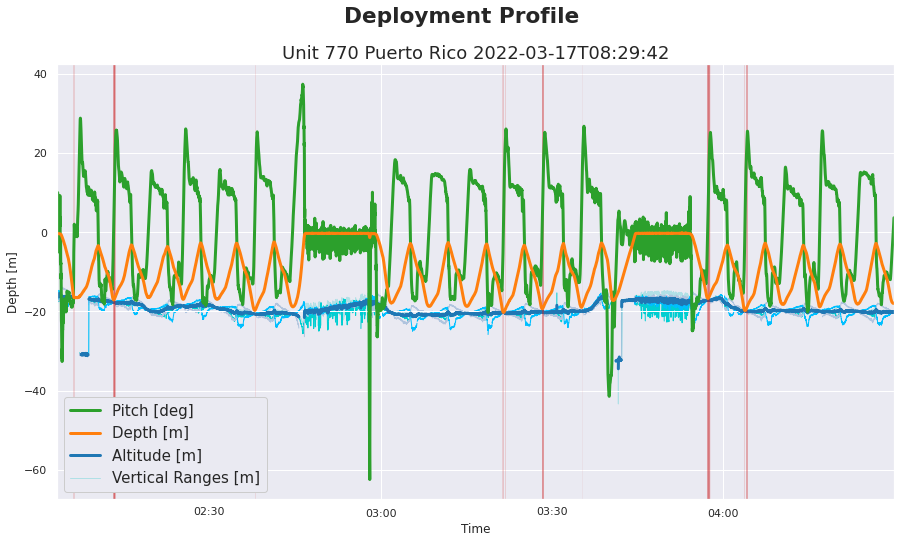

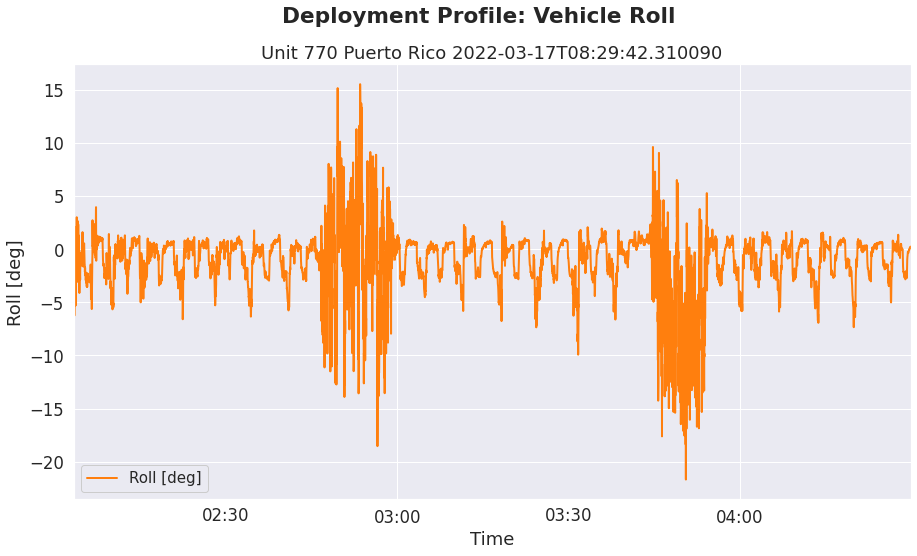

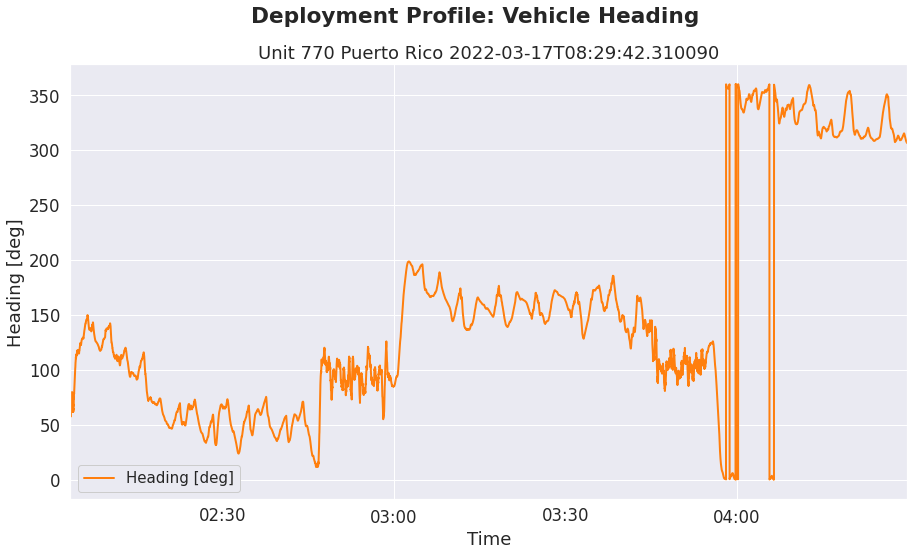

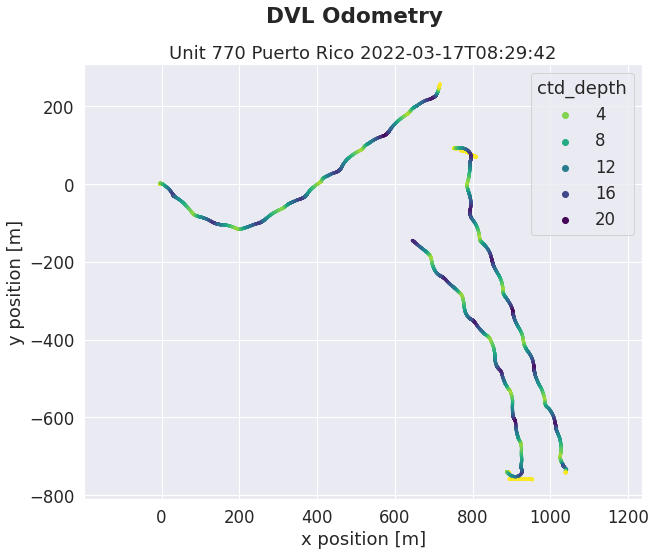

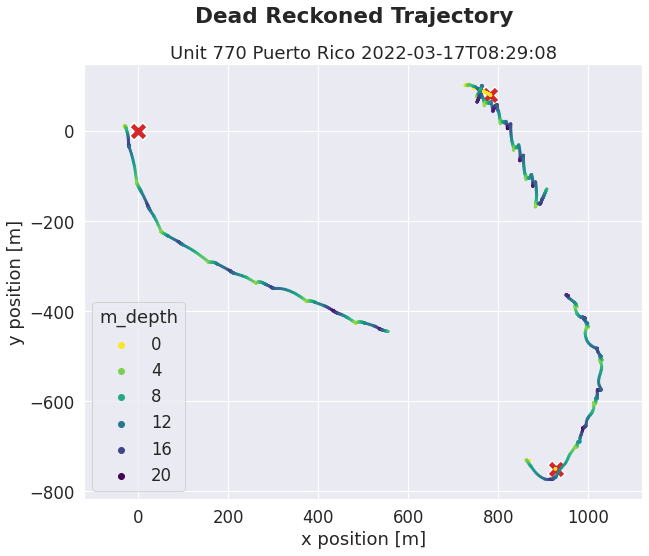

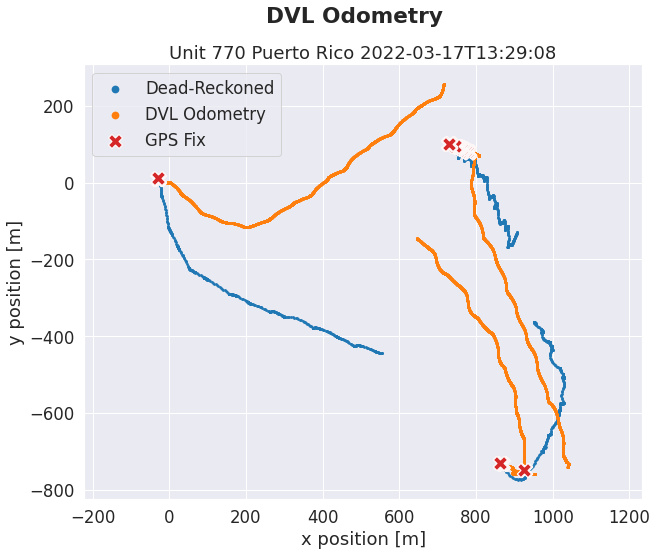

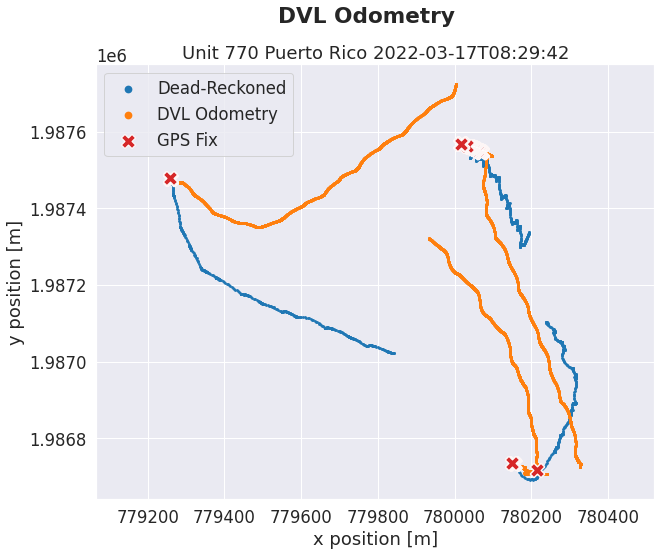

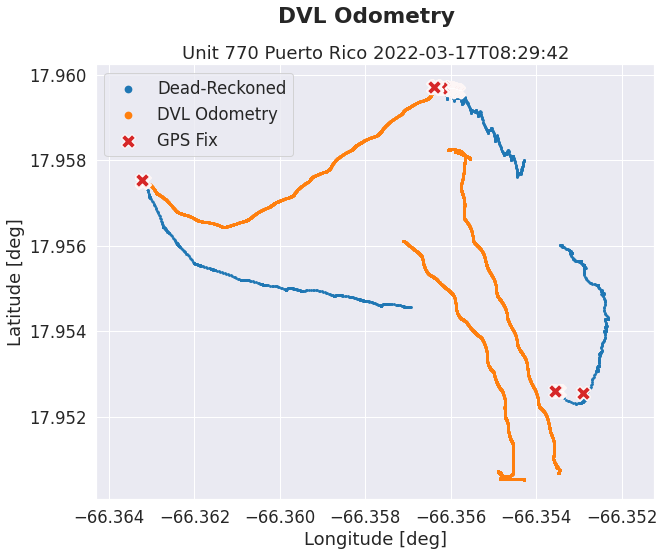

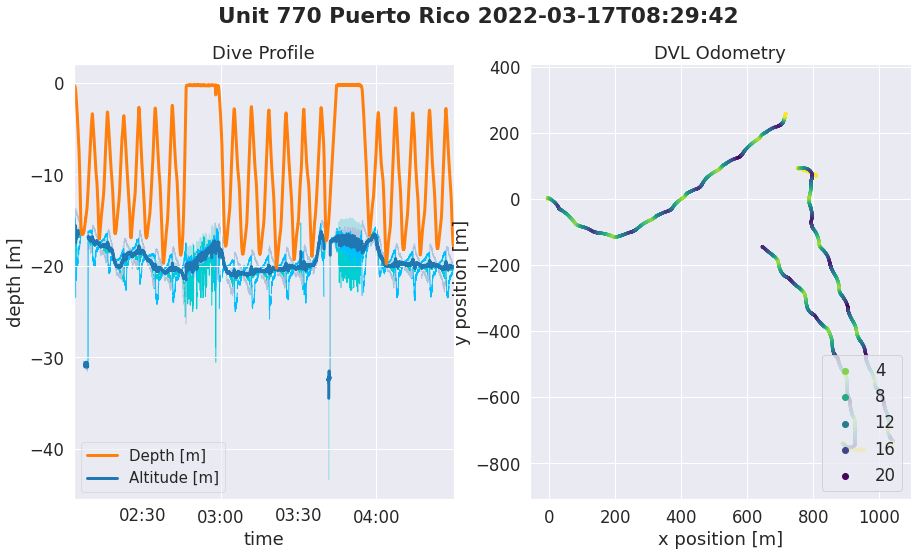

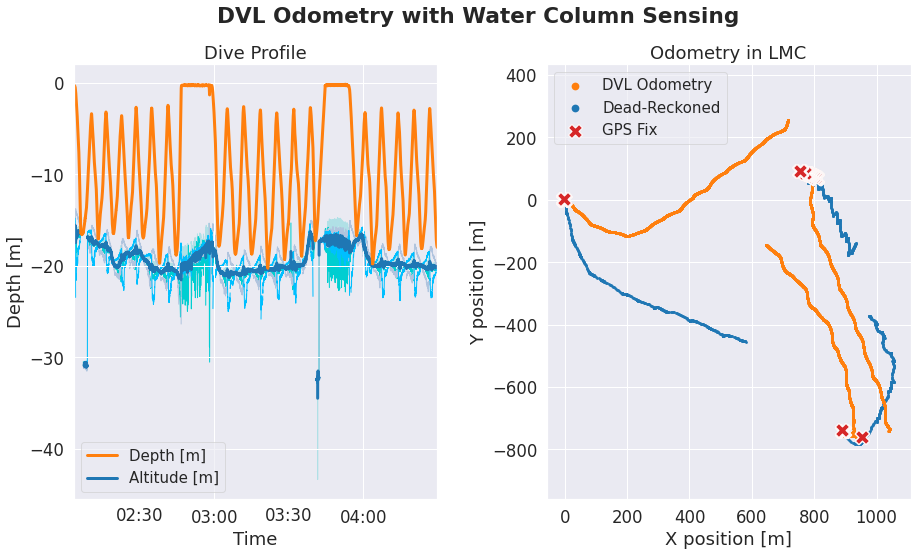

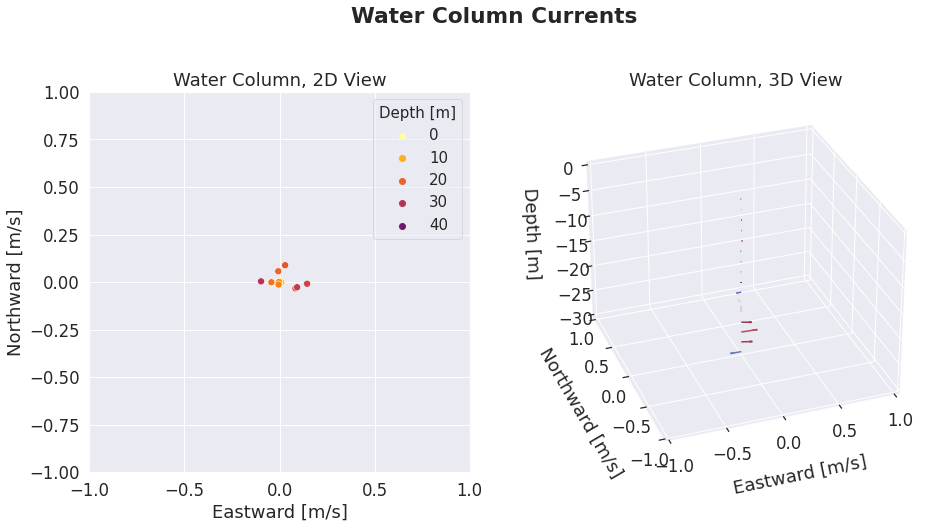

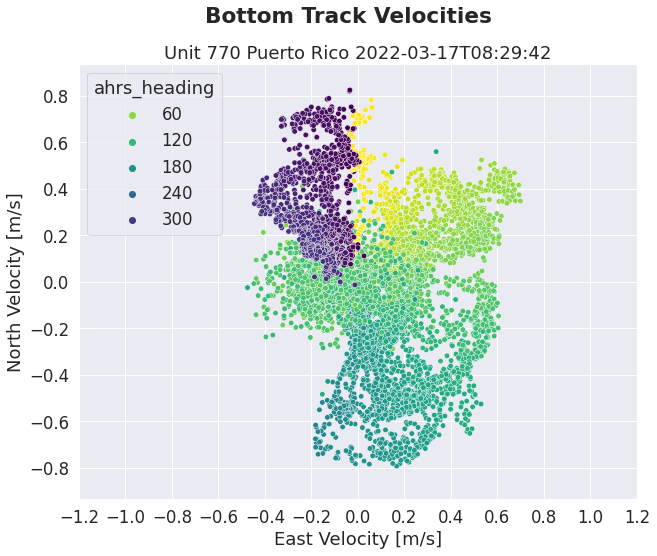

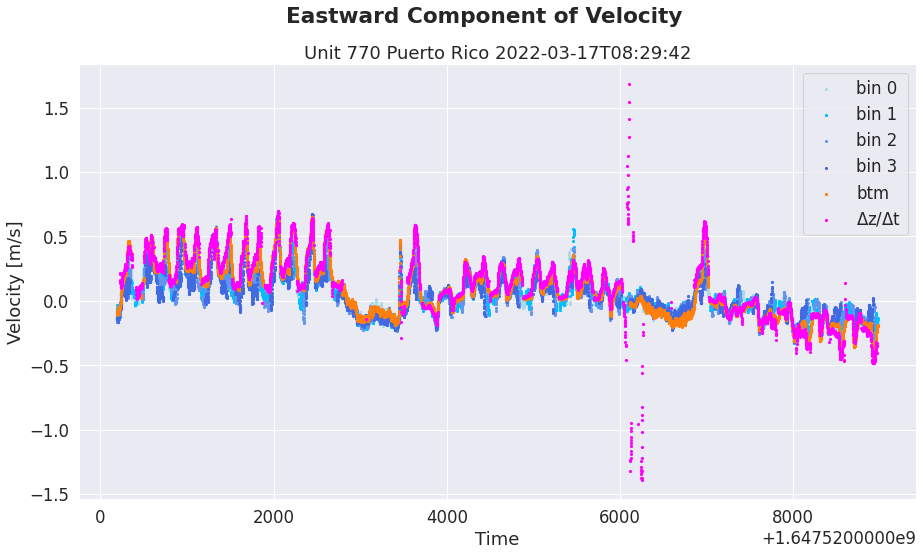

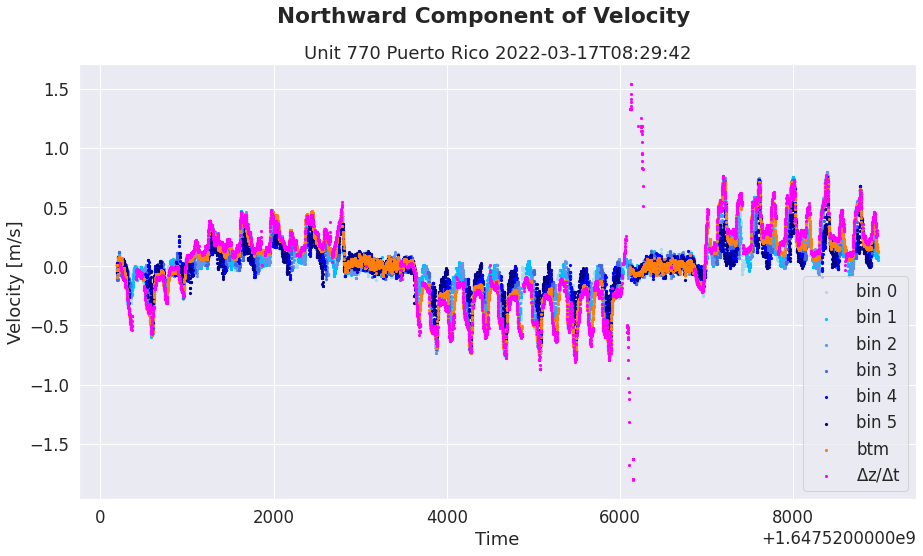

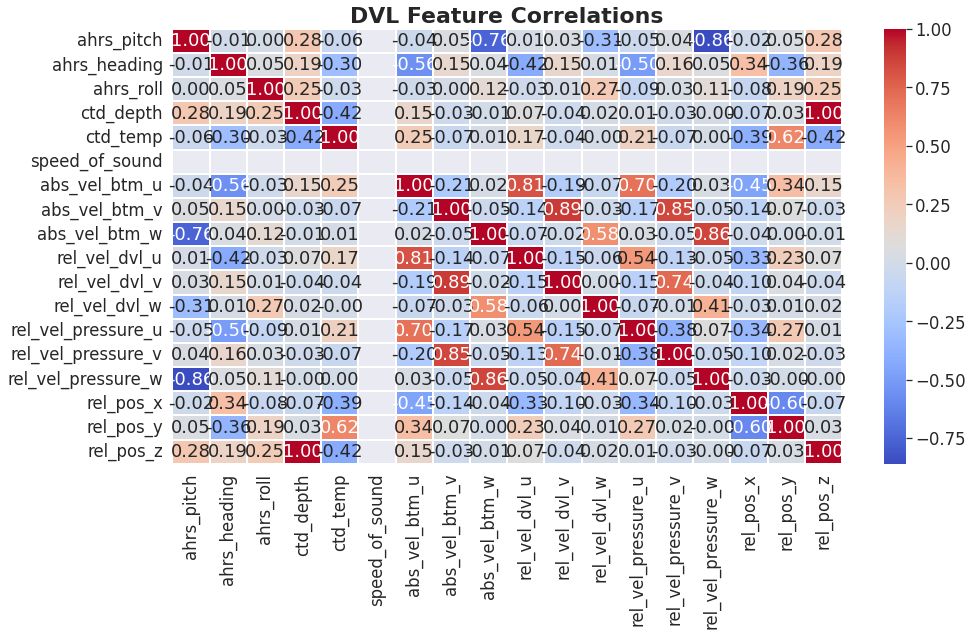

In [74]:
reload_modules()
# path_to_save_to = '/tmp/figs/'
path_to_save_to = '/home/gburgess/figs/prelim/mar17/' + selected_dive + '/'

df_dbd.to_csv(path_to_save_to + 'df_dbd.csv', sep=',', index=False)
ts.df.to_csv(path_to_save_to + 'df_dvl.csv')

# Deployment Profile
dvl_plotter_unit770_PR.plot_profile(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_profile.png')

# Plot Roll
dvl_plotter_unit770_PR.plot_roll(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_roll.png')

# Plot Heading
dvl_plotter_unit770_PR.plot_heading(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_heading.png')

# Plot just DVL-ODO Estimate (kinda useless)
dvl_plotter_unit770_PR.plot_odometry(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_dvl_odo_only.png')

# Plot just DR Estimate (also kinda useless)
dvl_plotter_unit770_PR.plot_m_odometry_dr(df_dbd, 'unit_770', save_name=path_to_save_to + selected_dive + '_dr_only.png')

# Plot Odometry and Dead Reckoned
dvl_plotter_unit770_PR.plot_odometry_and_dr(ts, df_dbd, 'unit_770', save_name=path_to_save_to + selected_dive + '_odo_and_dr.png')

# Plot Odometry and Dead Reckoned in UTM
dvl_plotter_unit770_PR.plot_odometry_and_dr_utm(ts, df_dbd, 'unit_770', save_name=path_to_save_to + selected_dive + '_odo_and_dr_utm.png')

# Plot Odometry and Dead Reckoned in LAT/LON
dvl_plotter_unit770_PR.plot_odometry_and_dr_lat_lon(ts, df_dbd, 'unit_770', save_name=path_to_save_to + selected_dive + '_odo_and_dr_LatLon.png')

# Plot Profile and Odometry
dvl_plotter_unit770_PR.plot_profile_and_odometry(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_profile_odo.png')

# Plot profile and odometry and DR
dvl_plotter_unit770_PR.plot_profile_and_odometry_and_dr(ts, df_dbd, save_name=path_to_save_to + selected_dive + '_profile_odo_dr.png')

# Plot Water Column
dvl_plotter_unit770_PR.plot_water_column_currents(voc_u_list, voc_v_list, voc_w_list, z_list, save_name=path_to_save_to + selected_dive + '_water_column.png')

# Plot Velocities (Bottom Track)
dvl_plotter_unit770_PR.plot_velocity_bottom_track(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_btm_track_vels.png')

# Plot Velocities (Eastward)
dvl_plotter_unit770_PR.plot_velocity_eastward(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_east_vels.png', filter_len=10, plt_pressure=True, plt_pitch=False)

# Plot Velocities (Northward)
dvl_plotter_unit770_PR.plot_velocity_northward(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_north_vels.png', roll_size=10, plt_pressure=True, plt_pitch=False)

# Plot Correlations
dvl_plotter_unit770_PR.plot_correlations(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_correlations.png')


In [ ]:
#MF-TAN things. Need to test on DAVE Desktop

#TODO
# Plot profile and navigation (edit and modify once MF-TAN is working)
# dvl_plotter_unit770_PR.plot_profile_and_navigation(ts, df_dbd, save_name=None)

#TODO
# Plot profile and Nav and Three Factors (edit and modify once MF-TAN is working)
# dvl_plotter_unit770_PR.plot_profile_and_odometry_and_dr_and_three_factors(ts, df_dbd ,bathy_df, save_name=None)

#TODO
# Plot profile and Nav and Slope factor
# dvl_plotter_unit770_PR.plot_profile_and_odometry_and_dr_and_slope_factor(ts, df_dbd, bathy_df, save_name=None)

#TODO
# Plot profile and odometry and DR and bathymetry
# dvl_plotter_unit770_PR.plot_profile_and_odometry_and_dr_and_bathymetry(ts, df_dbd, bathy_df, save_name=None)


In [62]:
# Exploitative Depth Band Selection 
#TODO would need to look into further

# plot_exploitative_depth_bands(dive_list, climb_list, TC_list,
#     glider_heading, voc_u_list, voc_v_list, voc_w_list, voc_z_list, 
#     save_name=None):

---
<a id='sandbox'></a>
## Sandbox

Text(0.5, 1.0, 'abs_vel_btm_v')

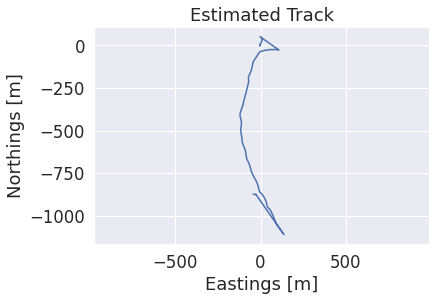

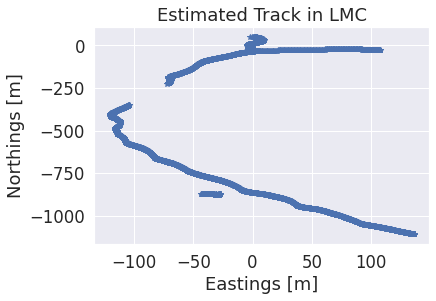

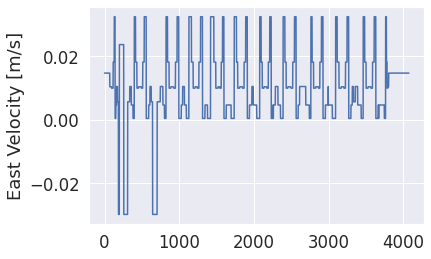

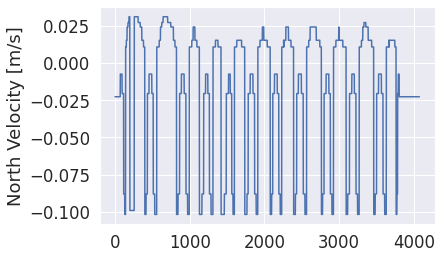

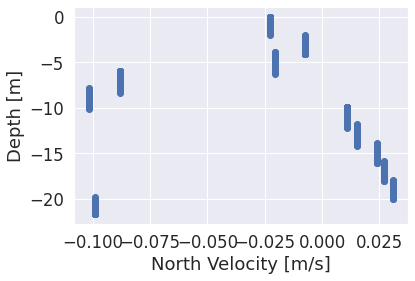

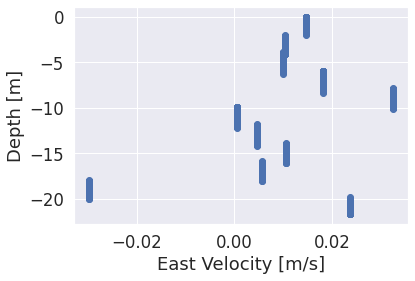

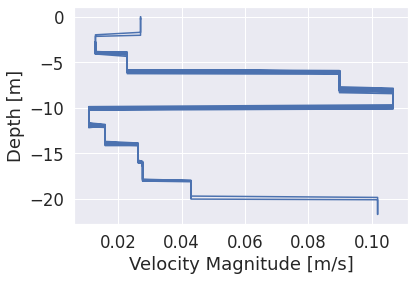

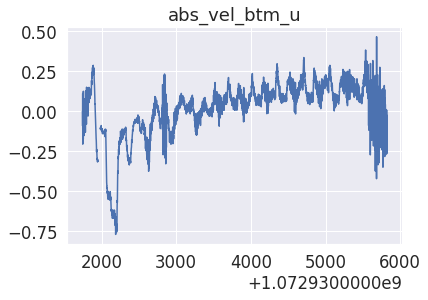

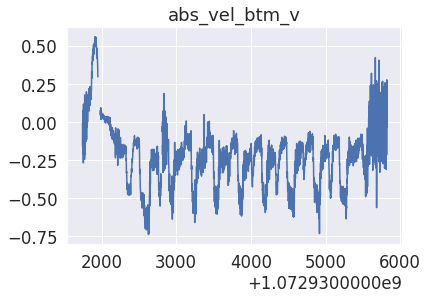

In [140]:
# Sandbox
plt.figure()
plt.plot(ts.df.rel_pos_x, ts.df.rel_pos_y)
#plt.plot(rel_pos_x_noBL, rel_pos_y_noBL)
plt.title('Estimated Track')
plt.axis('equal')
#plt.axis([-100, 350, -100, 800])
plt.xlabel('Eastings [m]')
plt.ylabel('Northings [m]')
#plt.plot(ts.df.rel_pos_x[num_bottom_lock_to_init], ts.df.rel_pos_y[num_bottom_lock_to_init], '+')
#plt.legend(['with bottom-lock', 'no bottom-lock'], loc='lower left', fontsize='xx-small')

plt.figure()
plt.plot(ts.df.rel_pos_x, ts.df.rel_pos_y, '*')
plt.title('Estimated Track in LMC')
plt.xlabel('Eastings [m]')
plt.ylabel('Northings [m]')
#plt.plot(rel_pos_x_noBL, rel_pos_y_noBL, '*')
#plt.plot(ts.df.rel_pos_x[num_bottom_lock_to_init], ts.df.rel_pos_y[num_bottom_lock_to_init], '+')
#plt.legend(['with bottom-lock', 'no bottom-lock'], loc='lower left', fontsize='xx-small')

plt.figure()
plt.plot(u_list)
plt.ylabel('East Velocity [m/s]')
             

plt.figure()
plt.plot(v_list)
plt.ylabel('North Velocity [m/s]')


plt.figure()
plt.plot(v_list,-ts.df.ctd_depth[0:-1], 'o')
plt.ylabel('Depth [m]')
plt.xlabel('North Velocity [m/s]')

plt.figure()
plt.plot(u_list, -ts.df.ctd_depth[0:-1],  'o')
plt.ylabel('Depth [m]')
plt.xlabel('East Velocity [m/s]')

u_list = np.array(u_list)
v_list = np.array(v_list)
magnitude = np.sqrt((v_list**2) + (u_list**2))
plt.figure()
plt.plot(magnitude, -ts.df.ctd_depth[0:-1])
plt.ylabel('Depth [m]')
plt.xlabel('Velocity Magnitude [m/s]')
#TODO re-bin at 3m for useful plot to help recognize (or not) accuracy --> trade off resolution for accuracy


plt.figure()
plt.plot(ts.df.time, ts.df.abs_vel_btm_u)
plt.title('abs_vel_btm_u')
plt.figure()
plt.plot(ts.df.time,ts.df.abs_vel_btm_v)
plt.title('abs_vel_btm_v')

> Finished Calculating Odometry!


(-79.97400202672844, 996.8380425612974, -801.7880259503821, 333.1705449580257)

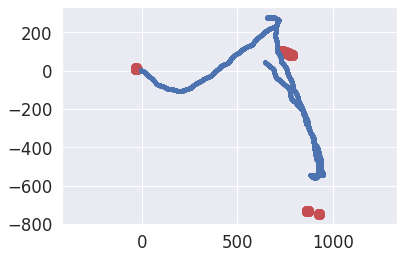

In [78]:
#Figure out rotation by using abs_vel to plot odometry
# plt.figure()
# plt.plot(ts.df.abs_vel_btm_u)
# plt.figure()
# plt.plot(ts.df.abs_vel_btm_v)
# plt.figure()
# plt.plot(ts.df.abs_vel_btm_w)

# initialize list for new odometry
rel_pos_x = [0]
rel_pos_y = [0]
rel_pos_z = [0]
delta_x_list = [0]
delta_y_list = [0]

vel_list_x = []
vel_list_y = []
u_list     = []
v_list     = []

# iterate through the dive file to update odometry
for t in range(1,len(ts.df)):
    time    = ts.df.ros_timestamp[t]
    prev_x  = rel_pos_x[-1]
    prev_y  = rel_pos_y[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.ctd_depth[t]
    

    # retrieve over ground velocity from DVL in bottom track 
    vog_u = ts.df.abs_vel_btm_u[t]
    vog_v = ts.df.abs_vel_btm_v[t]
   
    # initialize delta values to zero
    delta_x, delta_y = 0,0
    
    # CASE 1: use bottom track overground velocity if available
    if (not np.isnan(vog_u)):
        delta_x = vog_u*delta_t
        delta_y = vog_v*delta_t
        vel_list_x.append(vog_u)
        vel_list_y.append(vog_v)
    

    # set current position to DVL odometry result 
    cur_x = delta_x + prev_x
    cur_y = delta_y + prev_y
    
    # update the odometry list of positions
    rel_pos_x.append(cur_x)
    rel_pos_y.append(cur_y)
    rel_pos_z.append(depth)
    delta_x_list.append(delta_x)
    delta_y_list.append(delta_y)
    
    
# add new odomety to the data frame
ts.df['rel_pos_x'] = rel_pos_x
ts.df['rel_pos_y'] = rel_pos_y
ts.df['rel_pos_z'] = rel_pos_z
ts.df['delta_x']   = delta_x_list
ts.df['delta_y']   = delta_y_list

print("> Finished Calculating Odometry!") 

plt.figure()
plt.plot(df_dbd.m_gps_x_lmc, df_dbd.m_gps_y_lmc, 'ro', markersize=10)
# plt.plot(df_dbd.m_x_lmc, df_dbd.m_y_lmc, '.g' )
plt.plot(ts.df.rel_pos_x, ts.df.rel_pos_y, '.b')
#plt.legend(['GPS', 'DR', 'ABS_VEL_BTM'])
plt.axis('equal')